This notebook is related to the **Machine Learning - Final Project**, in the 'Machine Learning' course, Nova IMS.

Deadline May 31st 2020

Group: 40

* Viktor Jamiolkowski - M20190329
* Bojan Stavrijk - M20190562
* Henrique Januário - M20190438
* Francisco Jorge - M20190863
* Pedro Carmora - R2016645

## Notebook Contents

* [1. Overview of the Dataset](#overview)
* [2. Attribute Analysis](#aa)
    * [Correlation of features](#cor)
* [3. Attribute Preprocessing (Cleaning)](#clean)
* [4. Classifier Baseline Benchmark](#bench)
* [5. Feature Engineering](#fe)
    * [Feature Scaling](#fs)
    * [Boruta/Lasso Regression for Feature Selection](#fs)
* [6. Hyperparameter Tuning](#hypert)
    * RandomizedSearchCV
* [7. Prediction on Test_Set](#pred)
    * Classify Train_Set and Submit to Kaggle

In [161]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from pandas.plotting import scatter_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.impute import (SimpleImputer,
                            KNNImputer)

from sklearn.linear_model import (SGDClassifier, 
                                  LogisticRegression)

from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     GridSearchCV)

from sklearn.preprocessing import (Normalizer,
                                   MinMaxScaler,
                                   LabelEncoder,
                                   RobustScaler,
                                   StandardScaler,OneHotEncoder)

from sklearn.neural_network import (MLPClassifier, 
                                    BernoulliRBM)


In [49]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)
sns.set_style(style = 'white')
colors = sns.color_palette("YlGnBu_r", 6)

In [50]:
#Exclude Gender from Name
def gender_split(df):
    name = df['Name'].str.split(' ',n=1, expand=True)
    df['Gender'] = name[0]
    df['Name'] = name[1]
    df['Gender'] = df['Gender'].replace(['Miss','Mrs.','Ms.','Mr.','Master'],[0,0,0,1,1])
    return df['Gender']

In [51]:
def scaler_selection(X_train, X_val, y_train, y_val, model):
    """
    Pass in different models and receive the results for 
    different classifiers. Please change the column_name if required
    """
    
    column_name=['KNN','LR','NB','BGD']

    df = pd.DataFrame(index=['Normalizer_test','Robust_test','Minmax_test','Minmax_test2','Standard_test']
                      ,columns=column_name)
    i=0
    for mode in model:
        
        
        #Normalizer
        transformer = Normalizer()
        transformer.fit(X_train)

        transformer_X_train = transformer.transform(X_train)
        transformer_X_val = transformer.transform(X_val)

        model_baseline_transformer = mode
        model_baseline_transformer.fit(transformer_X_train, y_train)

        transformerf1_val = model_baseline_transformer.score(transformer_X_val,y_val)


        #RobustScaler
        robust_scaler = RobustScaler()
        robust_scaler.fit(X_train)

        robust_X_train = robust_scaler.transform(X_train)
        robust_X_val = robust_scaler.transform(X_val)

        model_baseline_robust = mode
        model_baseline_robust.fit(robust_X_train, y_train)
        robustf1_val = model_baseline_robust.score(robust_X_train,y_train)


        #MinMax(-1, 1)
        minmax = MinMaxScaler(feature_range=(-1, 1))
        minmax.fit(X_train)

        min_max_X_train = minmax.transform(X_train)
        min_max_X_val = minmax.transform(X_val)

        min_max_model = mode
        min_max_model.fit(min_max_X_train, y_train)
        minmaxf1_val = min_max_model.score(min_max_X_val,y_val)


        #MinMax
        minmax2 = MinMaxScaler()
        minmax2.fit(X_train)

        min_max_X_train2 = minmax2.transform(X_train)
        min_max_X_val2 = minmax2.transform(X_val)

        min_max_model2 = mode
        min_max_model2.fit(min_max_X_train2, y_train)
        minmaxf1_val2 = min_max_model2.score(min_max_X_val2,y_val)


        #StandardScaler
        standardscaler = StandardScaler()
        standardscaler.fit(X_train)

        standardscaler_X_train = standardscaler.transform(X_train)
        standardscaler_X_val = standardscaler.transform(X_val)

        standardscaler_model = mode
        standardscaler_model.fit(standardscaler_X_train, y_train)
        standard_f1_val = standardscaler_model.score(standardscaler_X_val,y_val)

        
        
      
        df[column_name[i]][0] = transformerf1_val
        df[column_name[i]][1] = robustf1_val
        df[column_name[i]][2] = minmaxf1_val     
        df[column_name[i]][3] = minmaxf1_val2
        df[column_name[i]][4] = standard_f1_val
        
        i+=1
        
    return df

In [52]:
def classifier_selection(X_train, X_val, y_train, y_val, classifier):
    """
    Pass in different classifiers and receive the results for 
    Please change the index_name if required
    """
    classifier_score_list=[]
    index_name=['KNN','LR','NB','GBC']

    df = pd.DataFrame(index=index_name, columns=['Results'])

    
    for classify in classifier:
    
        classifier = classify
        classifier.fit(X_train, y_train)
        classifier_score = classifier.score(X_val,y_val)
        print(classifier_score)
        classifier_score_list.append(classifier_score)
        
        
    df['Results']=classifier_score_list
    return df

<hr>
<a class="anchor" id="overview">

## 1. Overview of the Dataset
    
</a>

In [53]:
#Declaring a random state to be used where required
random_state = 42

In [54]:
df_raw = pd.read_csv('train.csv')

In [55]:
#Changes made because column names are incorrect
df_raw['Parents or children infected'] = df_raw['Parents or siblings infected']
df_raw = df_raw.drop('Parents or siblings infected', axis=1)

df_raw['Wife/Husband or siblings infected'] = df_raw['Wife/Husband or children infected']
df_raw = df_raw.drop('Wife/Husband or children infected', axis=1)

In [56]:
df_overview = df_raw.copy()

In [57]:
df_overview.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Medical_Expenses_Family,Medical_Tent,City,Deceased,Parents or children infected,Wife/Husband or siblings infected
0,1,4696,3,Miss Linda Betty,NaN,225,NaN,Santa Fe,1,0,0
1,2,21436,1,Ms. Ramona Elvira,1966.0,1663,NaN,Albuquerque,0,0,1
2,3,7273,3,Mr. Mario Vernon,1982.0,221,NaN,Santa Fe,1,0,0
3,4,8226,3,Mr. Hector Joe,1997.0,220,NaN,Santa Fe,1,0,0
4,5,19689,3,Ms. Jennie Debra,1994.0,222,NaN,Santa Fe,0,0,0


In [58]:
df_overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Medical_Expenses_Family            900 non-null    int64  
 6   Medical_Tent                       198 non-null    object 
 7   City                               898 non-null    object 
 8   Deceased                           900 non-null    int64  
 9   Parents or children infected       900 non-null    int64  
 10  Wife/Husband or siblings infected  900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [59]:
df_overview.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Medical_Expenses_Family,Deceased,Parents or children infected,Wife/Husband or siblings infected
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,895.743333,0.614444,0.380000,0.521111
std,259.951919,25418.153900,0.834223,14.523335,1385.829926,0.486997,0.803247,1.098385
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,221.000000,0.000000,0.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,405.000000,1.000000,0.000000,0.000000
75%,675.250000,18906.500000,3.000000,1999.500000,861.250000,1.000000,0.000000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,14345.000000,1.000000,6.000000,8.000000


**Considerations**
- 2 missing values for City
- 277 missing values for Birthday_year
- 702 missing values for Medical_Tent

- The best way to deal with the NaN values is:
    - Raplacing NaN with a value 

<hr>
<a class="anchor" id="aa">

## 2. Attribute Analysis
    
</a>

In [334]:
#Create a stratified train_set and test_set with an equal number of target features
df_analysis = df_raw.copy()

#Alternative - Medical_Tent create Dummy Variables for each Tent
df_analysis['Medical_Tent'] = df_analysis['Medical_Tent'].fillna('NaN')
df_analysis['Medical_Tent'] = df_analysis['Medical_Tent'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T','NaN'],[0, 1, 2, 3, 4 ,5 ,6 ,7 , 10])

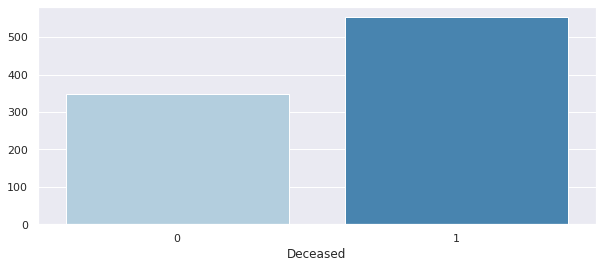

In [335]:
# Target distribution

sns.set(rc={'figure.figsize':(10,4)},)

target_distribution = df_analysis.groupby('Deceased').size()
sns.color_palette("Blues")
ax = sns.barplot(x=target_distribution.index,y=target_distribution,palette="Blues")

**Considerations**
- The data is imbalanced in respect to the target
- Thus several approaches will be tested: random oversampling, random undersampling or hybrid approaches

[]

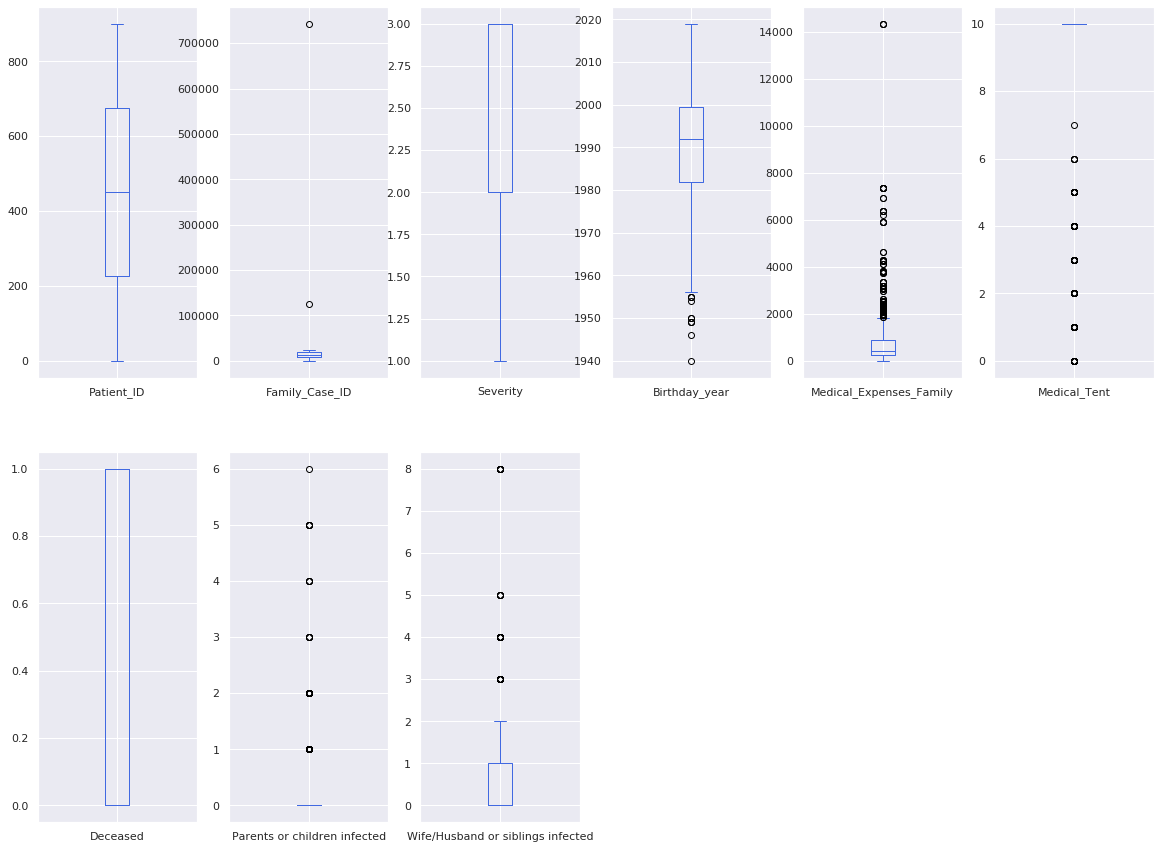

In [321]:
#Box Plots show the distribution of the features and help to identify anormal distributions
df_analysis.plot(kind='box', subplots=True, layout=(2,6), figsize=(20,15), color = 'royalblue')
plt.plot()

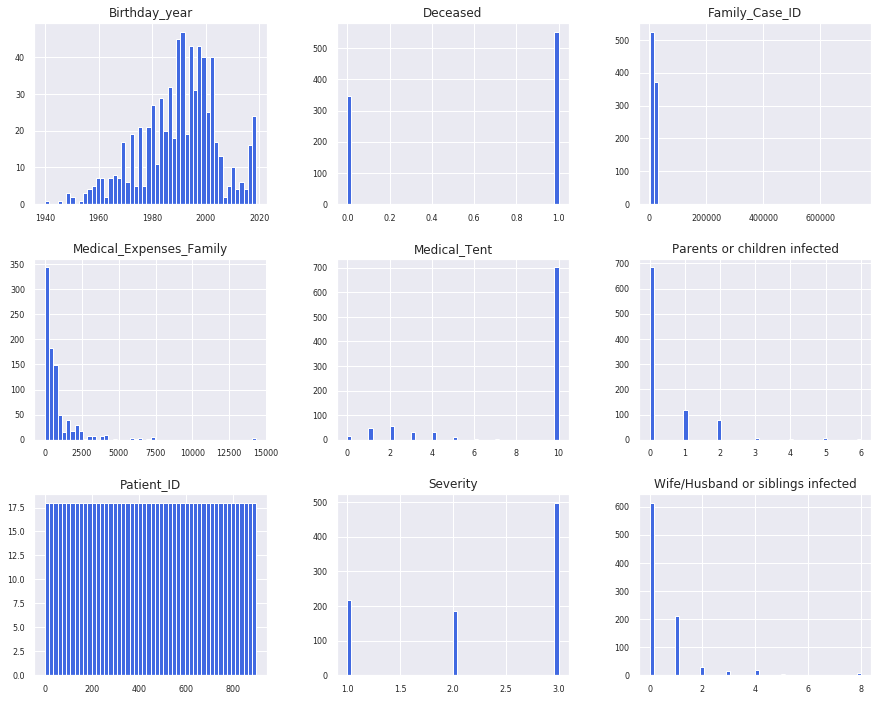

In [322]:
hist = df_analysis.hist(figsize = (15,12), bins = 50, xlabelsize = 8, ylabelsize = 8, color = 'royalblue')

**Considerations**
- Several attributes such as Medical_Expenses_family or Age show a a-normal distrubtion and might require to standardize its data and remove outliers
- The Medical_Tent shows a large concentration on Tent 10 which was previously labeled as NaN

#### Followingly let's have a closer look on the distribution of attributes to the target


In [340]:
cat_cols = df_analysis.select_dtypes(include = 'object').columns.values
cat_cols


array(['Name'], dtype=object)

In [341]:
#Encode Attributes to compare with Label
le = LabelEncoder()
le.fit(df_analysis.Medical_Tent)
df_analysis.Medical_Tent = le.transform(df_analysis.Medical_Tent)

df_analysis.City = df_analysis.City.astype(str)
le = LabelEncoder()
le.fit(df_analysis['City'])
df_analysis.City = le.transform(df_analysis.City)

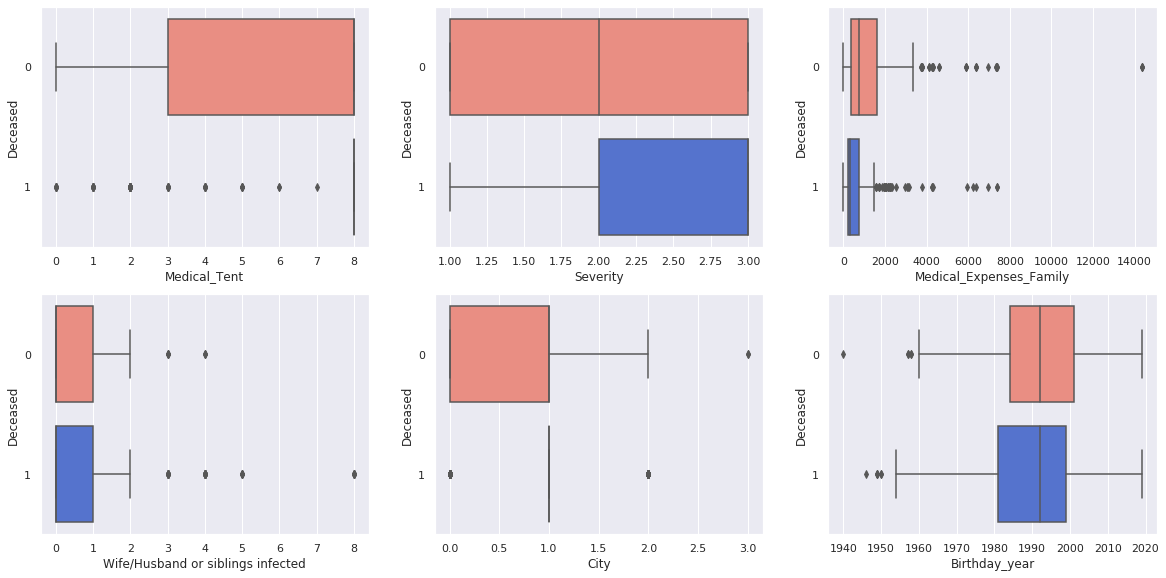

In [342]:
#Plot of Attribute to Label distribution
palette = ["salmon","royalblue"]
sns.set_palette(palette)

f = plt.figure(figsize=(20, 15))
gs = f.add_gridspec(3,3)

ax = f.add_subplot(gs[0, 0])
sns.boxplot(data = df_analysis, x = 'Medical_Tent', y = 'Deceased', orient = 'h')

ax = f.add_subplot(gs[0, 1])
sns.boxplot(data = df_analysis, x = 'Severity', y = 'Deceased',  orient = 'h')

ax = f.add_subplot(gs[0, 2])
sns.boxplot(data = df_analysis, x = 'Medical_Expenses_Family', y = 'Deceased',  orient = 'h')

ax = f.add_subplot(gs[1, 0])
sns.boxplot(data = df_analysis, x = 'Wife/Husband or siblings infected', y = 'Deceased', orient = 'h')

ax = f.add_subplot(gs[1, 1])
sns.boxplot(data = df_analysis, x = 'City', y = 'Deceased', orient = 'h')

ax = f.add_subplot(gs[1, 2])
sns.boxplot(data = df_analysis, x = 'Birthday_year', y = 'Deceased', orient = 'h')

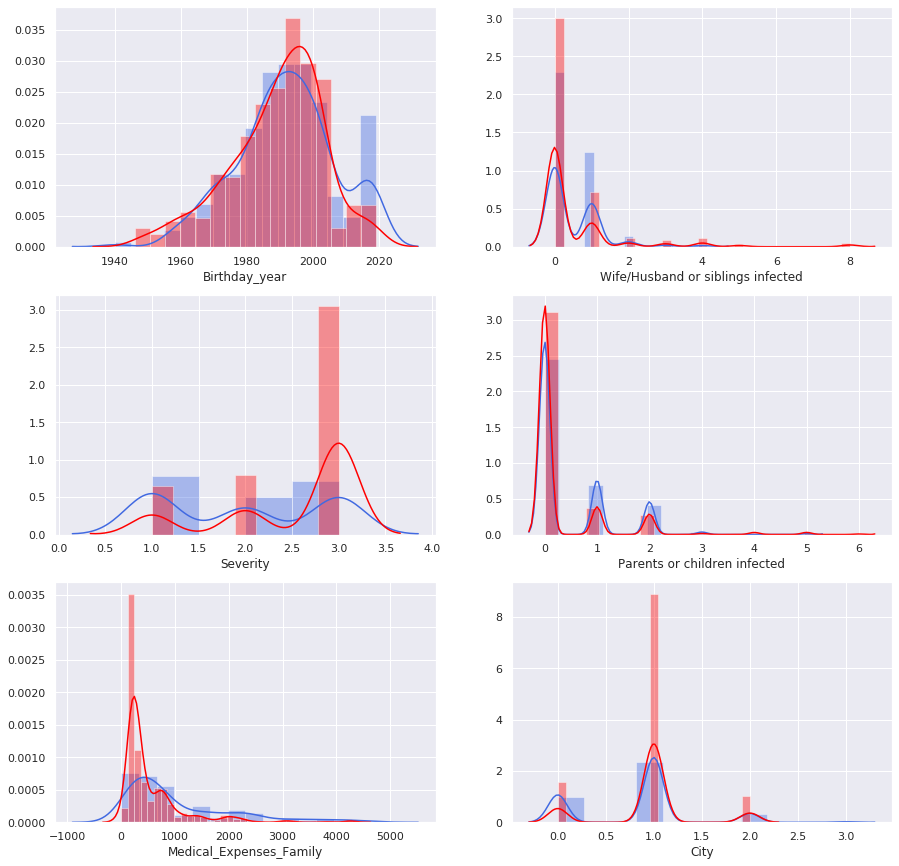

In [344]:
#Lets use a distplot to see the relation from a different perspective
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15,15))

sns.distplot( df_analysis[df_analysis['Deceased'] == 0]["Birthday_year"] , color="royalblue", label="Deceased",ax=axs[0,0])
sns.distplot( df_analysis[df_analysis['Deceased'] == 1]["Birthday_year"] , color="red", label="Deceased",ax=axs[0,0])


sns.distplot( df_analysis[df_analysis['Deceased'] == 0]["Severity"] , color="royalblue", label="Deceased",ax=axs[1,0])
sns.distplot( df_analysis[df_analysis['Deceased'] == 1]["Severity"] , color="red", label="Deceased",ax=axs[1,0])

sns.distplot( df_analysis[df_analysis['Deceased'] == 0]["Wife/Husband or siblings infected"] , color="royalblue", label="Deceased",ax=axs[0,1])
sns.distplot( df_analysis[df_analysis['Deceased'] == 1]["Wife/Husband or siblings infected"] , color="red", label="Deceased",ax=axs[0,1])

sns.distplot( df_analysis[df_analysis['Deceased'] == 0]["Parents or children infected"] , color="royalblue", label="Deceased", kde_kws={'bw':0.1},ax=axs[1,1])
sns.distplot( df_analysis[df_analysis['Deceased'] == 1]["Parents or children infected"] , color="red", label="Deceased", kde_kws={'bw':0.1},ax=axs[1,1])

sns.distplot( df_analysis[(df_analysis['Deceased'] == 0) & (df_analysis['Medical_Expenses_Family'] < 5000)]["Medical_Expenses_Family"] , color="royalblue", label="Deceased",ax=axs[2,0])
sns.distplot( df_analysis[(df_analysis['Deceased'] == 1) & (df_analysis['Medical_Expenses_Family'] < 5000)]["Medical_Expenses_Family"], color="red", label="Deceased",ax=axs[2,0])

sns.distplot( df_analysis[df_analysis['Deceased'] == 0]["City"] , color="royalblue", label="Deceased", kde_kws={'bw':0.1},ax=axs[2,1])
sns.distplot( df_analysis[df_analysis['Deceased'] == 1]["City"] , color="red", label="Deceased", kde_kws={'bw':0.1},ax=axs[2,1])

plt.show()

In [347]:
# Lets have a closer look on the Medical_Tent variable which showed a strong relation to mortalities 
df_analysis['Medical_Tent'] = df_analysis['Medical_Tent'].fillna('NaN')
df_analysis['Medical_Tent'].value_counts(sort=True,dropna=False)
df_analysis_mt = df_analysis.groupby('Medical_Tent')['Deceased'].count()
df_analysis_mt

Medical_Tent
0     15
1     46
2     57
3     31
4     31
5     13
6      4
7      1
8    702
Name: Deceased, dtype: int64

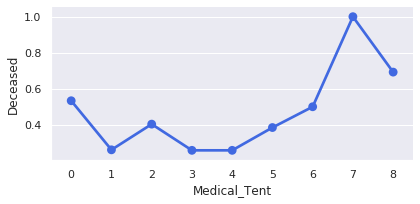

In [348]:
# people assigned to no tent have a much higher mortality rate, although tent T has devastating results

temp = df_analysis[['Medical_Tent','Deceased']].groupby('Medical_Tent').mean().reset_index()
sns.factorplot('Medical_Tent', 'Deceased', size=3, aspect=2, data=temp, color="royalblue")
del temp

**Considerations**
- The boxplot and distribution plot showed certain trends in relation to the Mortality rate
- Certain attributes such like Medical_Tent, Severity, City or Medical_Expenses_Family show a stronger likelihood to mortalities
- The age influences the deceased status in which older individuals tend to be endangered more strongly
- Also the severity tends to be higher for deceased individuals

<hr>
<a class="anchor" id="cor">

### Correlation of features
    
</a>

In [350]:
#Our findings from the distrution should be underpinned by correlations
corr_matrix = df_analysis.corr()
corr_matrix['Deceased'].sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.333286
Medical_Tent                         0.286598
City                                 0.118176
Wife/Husband or siblings infected    0.032909
Family_Case_ID                       0.021400
Patient_ID                           0.003282
Birthday_year                       -0.081879
Parents or children infected        -0.082862
Medical_Expenses_Family             -0.254510
Name: Deceased, dtype: float64

In [326]:
cols = list(df_analysis.columns.values)
cols
data = df_analysis[['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year','Medical_Expenses_Family','Medical_Tent','City','Parents or children infected','Wife/Husband or siblings infected','Deceased']]

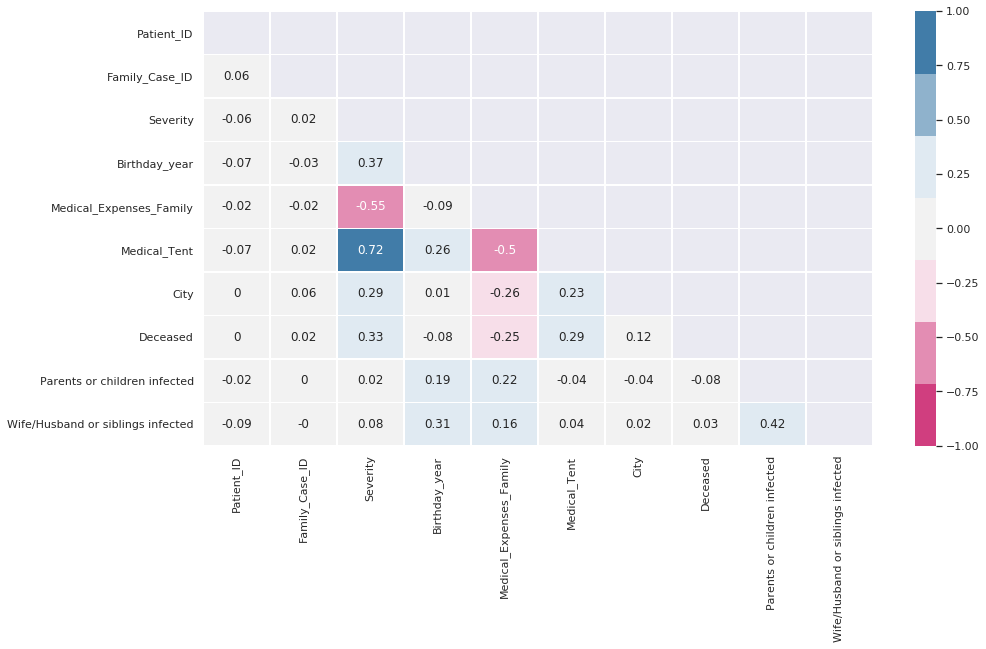

In [327]:
corr = df_analysis.corr('pearson').round(decimals=2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True, 
            linewidths=.5, 
            vmin = -1.0,
            vmax = 1.0,
            mask = mask,
            cmap=sns.diverging_palette(-10, 240, sep=70, n=7)
           )

**Considerations**
- Indeed regarding the target, three factors play a larger role than others Severity, Medical_Expenses_Family and Medical_Tent
- Because the former attribute includes many missing values, our focus is to recreate the missing values in the most insightful way possible
- In practive we plan to consider a NaN Medical_Tent value to indicate that no Tent was visited by the patient and thus its deceasment rate is several magnitudes larger then the patient treated in a Medical_Tent

<hr>
<a class="anchor" id="clean">

## 3. Data Cleaning
    
</a>

In [130]:
df_cleaning = df_raw.copy()

In [131]:
df_cleaning = df_cleaning.reset_index(drop=True)
df_cleaning.Medical_Tent.unique()

array([nan, 'F', 'B', 'A', 'E', 'C', 'D', 'G', 'T'], dtype=object)

In [132]:
#City removing two missing values
df_cleaning = df_cleaning.dropna(subset=['City'])

#Medical_Tent
df_cleaning['Medical_Tent'] = df_cleaning['Medical_Tent'].fillna('NaN')
df_cleaning['Medical_Tent'] = df_cleaning['Medical_Tent'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T','NaN'],[1, 1, 1, 1, 1 ,1 ,1 ,1 , 0])

#Birthday_year replace NaN's by KNN
from sklearn.impute import KNNImputer
imp = KNNImputer()
imp.fit(df_cleaning['Birthday_year'].values.reshape(-1, 1))
df_cleaning['Birthday_year'] = imp.fit_transform(df_cleaning['Birthday_year'].values.reshape(-1, 1)).round(0).astype(int)


#Categorical City attributes to dummy variables
df_cleaning.City = df_cleaning.City.replace(['Albuquerque', 'Santa Fe', 'Taos'],[0, 1, 2])


In [133]:
df_cleaning.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Medical_Expenses_Family,Medical_Tent,City,Deceased,Parents or children infected,Wife/Husband or siblings infected
0,1,4696,3,Miss Linda Betty,1990,225,0,1,1,0,0
1,2,21436,1,Ms. Ramona Elvira,1966,1663,0,0,0,0,1
2,3,7273,3,Mr. Mario Vernon,1982,221,0,1,1,0,0
3,4,8226,3,Mr. Hector Joe,1997,220,0,1,1,0,0
4,5,19689,3,Ms. Jennie Debra,1994,222,0,1,0,0,0


<hr>
<a class="anchor" id="bench">

## 4. Classifier Baseline Benchmark 
    
</a>

In [134]:
df_bench = df_cleaning.copy()
df_bench = df_bench.drop(['Name','Patient_ID'],axis=1)

In [135]:
#Create an X and y for train_test_split
target_name = 'Deceased'
X = df_bench.loc[:, df_bench.columns != target_name]
y = df_bench.loc[:, df_bench.columns == target_name]

In [136]:
from imblearn.over_sampling import SMOTE
# Smote method was considered, although it shows better score for gradientboosting classifier (Almost 0.8),
# it resulted in a lower score overall on kaggle (~0.83)

#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)
#y.Deceased.value_counts()

In [137]:
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=random_state,
                                                  stratify=y)

In [138]:
classifier_selection(X_train, X_val, y_train, y_val,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),GradientBoostingClassifier()])

0.6944444444444444
0.6833333333333333
0.7666666666666667
0.75


,Results
KNN,0.694444
LR,0.683333
NB,0.766667
GBC,0.750000


**Considerations**
- The classifier needs to get better data as the performance is very low
- Change Tent into Dummy variables as well and retest

<hr>
<a class="anchor" id="fe">

## 5. Feature Engineering
    
</a>

In [139]:
df_feat = df_cleaning.copy()

# Derive Gender from Name
df_feat['Gender'] = gender_split(df_feat)

#Drop Name
df_feat = df_feat.drop('Name',axis=1)

# Feature extraction from medical expenses data
#Medical_Expenses_Family Ratio
df_feat['Ratio_Medical_Exp'] = df_feat.loc[:,'Medical_Expenses_Family']/df_feat.loc[:,'Medical_Expenses_Family'].mean()

#Age/MeanAge Ratio
df_feat['Age_MeanAge'] = df_feat.loc[:,'Birthday_year']/df_feat.loc[:,'Birthday_year'].mean()

#Medical_Expenses_Family Gender Ratio
rat = df_feat.groupby('Gender')['Medical_Expenses_Family'].transform('mean')
df_feat = df_feat.assign(Ratio_gender_med=lambda x: x.Medical_Expenses_Family.div(rat))

#Severity by Average Gender Ratio
rat = df_feat.groupby('Gender')['Severity'].transform('mean')
df_feat = df_feat.assign(Average_Severity_Gender_Ratio=lambda x: x.Severity.div(rat))

df_feat.head()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Medical_Expenses_Family,Medical_Tent,City,Deceased,Parents or children infected,Wife/Husband or siblings infected,Gender,Ratio_Medical_Exp,Age_MeanAge,Ratio_gender_med,Average_Severity_Gender_Ratio
0,1,4696,3,1990,225,0,1,1,0,0,0,0.252030,0.999870,0.183463,1.377907
1,2,21436,1,1966,1663,0,0,0,0,1,0,1.862785,0.987811,1.355996,0.459302
2,3,7273,3,1982,221,0,1,1,0,0,1,0.247550,0.995850,0.310572,1.254310
3,4,8226,3,1997,220,0,1,1,0,0,1,0.246430,1.003387,0.309167,1.254310
4,5,19689,3,1994,222,0,1,0,0,0,0,0.248670,1.001879,0.181017,1.377907


In [140]:
#Gender shows high correlation with target
#Medical_Tent_Binary shows strong negative correlation -> if Tent is available death rate increases
#Family_Infected shows negative correlation
corr_matrix = df_feat.corr()
corr_matrix['Deceased'].sort_values(ascending=False)

Deceased                             1.000000
Gender                               0.539791
Severity                             0.330357
Average_Severity_Gender_Ratio        0.270771
City                                 0.131954
Wife/Husband or siblings infected    0.031639
Family_Case_ID                       0.022422
Patient_ID                           0.001555
Birthday_year                       -0.079661
Age_MeanAge                         -0.079661
Parents or children infected        -0.084364
Ratio_gender_med                    -0.152929
Ratio_Medical_Exp                   -0.252494
Medical_Expenses_Family             -0.252494
Medical_Tent                        -0.297630
Name: Deceased, dtype: float64

In [141]:
#Create X and y for train_test_split
target_name = 'Deceased'
X = df_feat.loc[:, df_feat.columns != target_name]
y = df_feat.loc[:, df_feat.columns == target_name]

y.Deceased.value_counts()

1    553
0    345
Name: Deceased, dtype: int64

In [142]:
#smote method considered, but it lowers score in the end

#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)
#y.Deceased.value_counts()

In [143]:
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=random_state,
                                                  stratify=y)

<hr>
<a class="anchor" id="fs">

### Feature Scaling
    
</a>

In [144]:
scaler_selection(X_train, X_val, y_train, y_val, [KNeighborsClassifier(),LogisticRegression(),GaussianNB(),GradientBoostingClassifier()])

,KNN,LR,NB,BGD
Normalizer_test,0.627778,0.616667,0.661111,0.85
Robust_test,0.846797,0.789694,0.724234,0.91922
Minmax_test,0.844444,0.844444,0.805556,0.838889
Minmax_test2,0.844444,0.844444,0.805556,0.844444
Standard_test,0.861111,0.844444,0.805556,0.838889


In [145]:
#Scale Features with best Scaler for Feature Selection
best_scaler = RobustScaler().fit(X_train)
X_train_scaled = best_scaler.transform(X_train)
X_val_scaled = best_scaler.transform(X_val)

**Considerations**
- Scaling improves the accuracy of our models measured with the X_val and y_val 
- We should create a method to test all classifiers on all scaler not just KNNClassifier

<hr>
<a class="anchor" id="fs">

### Feature Selection
    
</a>

- Regarding Feature Selection algorithms, BorutaPy uses a random forest classification and seems to be a good choice, according to this source: https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a
- Additionally a lasso regression is deployed to support the decisions made by BorutaPy

In [146]:
#Craeting Train/Test Dataframe from the Scaling process to Select Features
X_train_Scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_val_Scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)

In [147]:
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=random_state)

# define Boruta feature selection method
feat_selector = BorutaPy(estimator = rf, n_estimators='auto', verbose=2, random_state=1, max_iter=200)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train_Scaled.values, y_train.values.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X_train_Scaled.values)

### print results
green_area = X_train_Scaled.columns[feat_selector.support_].to_list()
blue_area = X_train_Scaled.columns[feat_selector.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	9 / 200
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	10 / 200
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	11 / 200
Confirmed: 	8
Tentative: 	2
Rejected: 	4
Iteration: 	12 / 200
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 200
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 200
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 200
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 200
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration:

In [148]:
feature_df = pd.DataFrame(X_train_Scaled.columns.tolist(), columns=['features'])
feature_df['rank']=feat_selector.ranking_
feature_df['T/F']=feat_selector.support_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
feature_df

,features,rank,T/F
0,Severity,1,True
1,Birthday_year,1,True
2,Medical_Expenses_Family,1,True
3,Gender,1,True
4,Ratio_Medical_Exp,1,True
5,Age_MeanAge,1,True
6,Ratio_gender_med,1,True
7,Average_Severity_Gender_Ratio,1,True
8,Family_Case_ID,2,False
9,Medical_Tent,3,False


This feature reduction part wasn't used since it was found to reduce accuracy of our model.

<hr>
<a class="anchor" id="hypert">

## 6. Hyperparameter Tuning
    
</a>

### RandomizedSearchCV

In [149]:
X_final = X.copy()
y_final = y.copy()

final_scaler = RobustScaler().fit(X_final)
X_train = final_scaler.transform(X_final)
y_train = y_final.copy()

In [150]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators=list(range(50, 200, 10))
learning_rate= [0.0001,0.001,0.01,1]

classifier = GradientBoostingClassifier()

param_dictionary = dict(n_estimators=n_estimators,
                       learning_rate=learning_rate)


rand = RandomizedSearchCV(classifier, param_dictionary, cv=10, scoring='accuracy', n_iter=200, random_state=random_state,
                         n_jobs=-1)


rand.fit(X_train, y_train)

# examine the best model
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.8139950062421972
{'n_estimators': 80, 'learning_rate': 0.01}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [151]:
rand.best_params_

{'n_estimators': 80, 'learning_rate': 0.01}

In [152]:
classifier = GradientBoostingClassifier(n_estimators=80,learning_rate=0.01)

classifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [153]:
classifier.score(X_train, y_train)

0.8285077951002228

<hr>
<a class="anchor" id="pred">

## 7. Prediction on Test_Set
    
</a>

In [50]:
df_test = pd.read_csv('test.csv')

In [51]:
#Changes made because column names are incorrect
df_test['Parents or children infected'] = df_test['Parents or siblings infected']
df_test = df_test.drop('Parents or siblings infected', axis=1)

df_test['Wife/Husband or siblings infected'] = df_test['Wife/Husband or children infected']
df_test = df_test.drop('Wife/Husband or children infected', axis=1)

In [52]:
df_test.Medical_Tent.fillna('NaN').value_counts()

X    311
C     33
B     18
D     13
E      9
F      8
A      7
G      1
Name: Medical_Tent, dtype: int64

In [53]:
df_feat = df_test.copy()

data_test_id = df_feat['Patient_ID']
data_test_id = data_test_id.astype(int)

#City removing two missing values
df_feat = df_feat.dropna(subset=['City'])

# Derive Gender from Name
df_feat['Gender'] = gender_split(df_feat)

#Alternative - Medical_Tent create Dummy Variables for each Tent
df_feat['Medical_Tent'] = df_feat['Medical_Tent'].fillna('NaN')
df_feat['Medical_Tent'] = df_feat['Medical_Tent'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T','NaN'],[1, 1, 1, 1, 1 ,1 ,1 ,1 , 0])

#Birthday_year replace NaN's by KNN
imp = KNNImputer()
imp.fit(df_feat['Birthday_year'].values.reshape(-1, 1))
df_feat['Birthday_year'] = imp.fit_transform(df_feat['Birthday_year'].values.reshape(-1, 1)).round(0).astype(int)

#Categorical City attributes to dummy variables
df_feat.City = df_feat.City.replace(['Albuquerque', 'Santa Fe', 'Taos'],[0, 1, 2])

#Drop Name
df_feat = df_feat.drop('Name',axis=1)


#Medical_Expenses_Family Ratio
df_feat['Ratio_Medical_Exp'] = df_feat.loc[:,'Medical_Expenses_Family']/df_feat.loc[:,'Medical_Expenses_Family'].mean()

#Age/MeanAge Ratio
df_feat['Age_MeanAge'] = df_feat.loc[:,'Birthday_year']/df_feat.loc[:,'Birthday_year'].mean()

#Medical_Expenses_Family Gender Ratio
rat = df_feat.groupby('Gender')['Medical_Expenses_Family'].transform('mean')
df_feat = df_feat.assign(Ratio_gender_med=lambda x: x.Medical_Expenses_Family.div(rat))

#Severity by Average Gender Ratio
rat = df_feat.groupby('Gender')['Severity'].transform('mean')
df_feat = df_feat.assign(Average_Severity_Gender_Ratio=lambda x: x.Severity.div(rat))

In [54]:
df_feat_scaled = final_scaler.transform(df_feat)
y_pred_test_int = classifier.predict(df_feat_scaled)

In [55]:
predictedDF = pd.DataFrame(columns=['Patient_ID', 'Deceased'])

predictedDF['Patient_ID'] = data_test_id
predictedDF['Deceased'] = y_pred_test_int

In [56]:
predictedDF

,Patient_ID,Deceased
0,901,1
1,902,1
2,903,1
3,904,1
4,905,1
...,...,...
395,1296,1
396,1297,1
397,1298,0
398,1299,1


In [57]:
predictedDF.to_csv('m20190438_version4.csv', index=False,header=True)